In [16]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
torch.manual_seed(2)
torch.cuda.manual_seed(2)

g = torch.Generator()
g.manual_seed(1)


# Data preparation

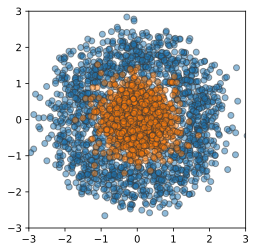

In [17]:
data_noise = 0.25
plotlim = [-3, 3]
subfolder = 'evo_circ'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('circles', noise = data_noise, plotlim = plotlim)


In [18]:
#We can now conveniently access the data from the dataloaders
for X_test, y_test in dataloader_viz:
    print(X_test[:10], y_test[:10])
    break
    

tensor([[ 1.4565,  1.3190],
        [-0.6323,  0.9188],
        [ 1.6289, -0.8966],
        [ 0.2478, -1.3378],
        [ 1.6661,  0.7088],
        [ 0.4404,  0.3704],
        [ 1.8317, -0.8183],
        [-0.3853,  0.5123],
        [-0.9403, -1.2358],
        [-0.1597,  0.4570]]) tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1])


# Model dynamics

In [19]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 5, 5 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside



torch.manual_seed(2)
torch.cuda.manual_seed(2)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 


print(anode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


In [20]:
torch.manual_seed(2)
torch.cuda.manual_seed(2)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 


print(rnode)

NeuralODE(
  (flow): Semiflow(
    (dynamics): Dynamics(
      (non_linearity): Tanh()
      (fc2_time): Sequential(
        (0): Linear(in_features=2, out_features=2, bias=True)
        (1): Linear(in_features=2, out_features=2, bias=True)
        (2): Linear(in_features=2, out_features=2, bias=True)
        (3): Linear(in_features=2, out_features=2, bias=True)
        (4): Linear(in_features=2, out_features=2, bias=True)
      )
    )
  )
  (linear_layer): Linear(in_features=2, out_features=2, bias=True)
  (non_linearity): Tanh()
)


# Classification Plot

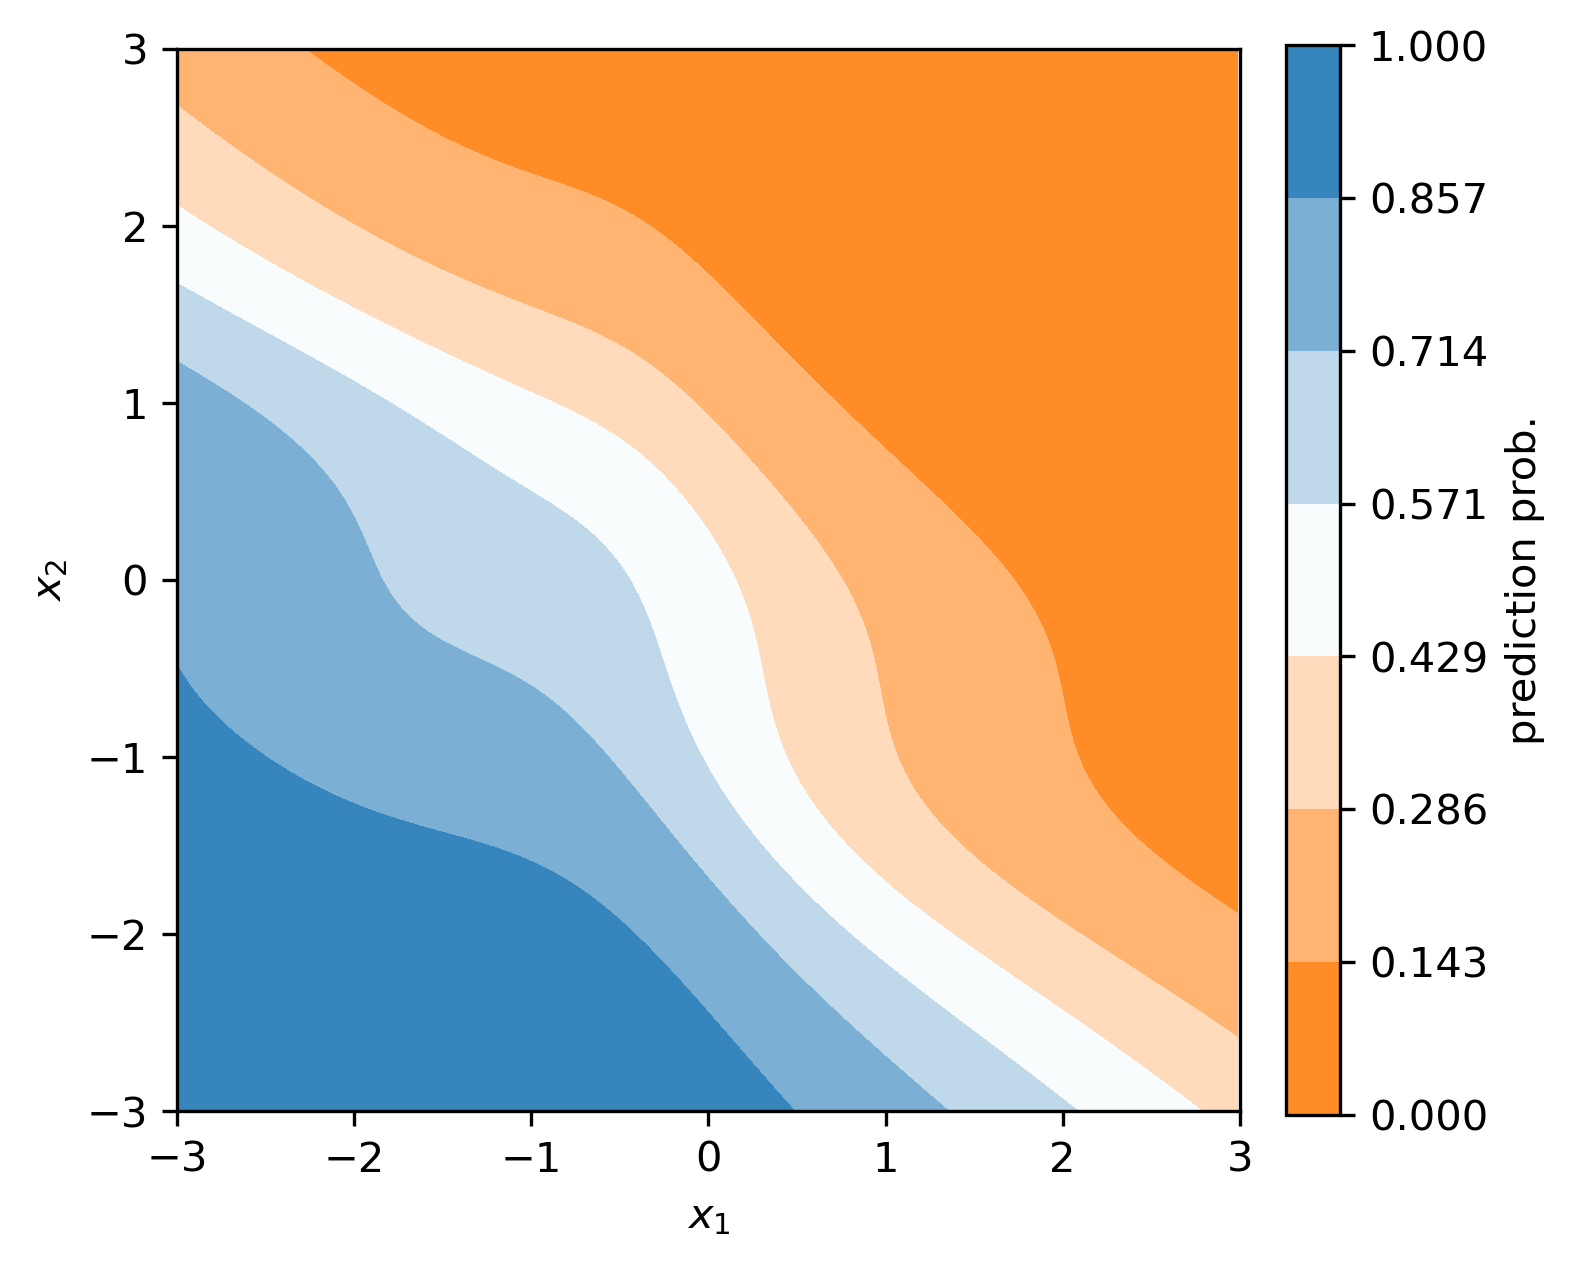

In [21]:
from plots.plots import classification_evolution

classification_evolution(rnode, fig_name = 'test' , plotlim = plotlim)
from IPython.display import Image
Image(filename = 'test.png', width = 600)

# Training and generating level sets

In [22]:
from models.training import Trainer, doublebackTrainer
import imageio, os
from plots.plots import train_to_classifier_imgs

num_epochs = 10 #number of optimization runs in which the dataset is used for gradient decent
plotfreq = 5


trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0, eps_comp = 0.2) 

   
train_to_classifier_imgs(anode, trainer_anode, dataloader, subfolder, num_epochs, plotfreq)


epoch =0
0.2

Iteration 0/45
Loss: 0.813
Robust Term Loss: 0.153
Accuracy: 0.656

Iteration 10/45
Loss: 0.832
Robust Term Loss: 0.160
Accuracy: 0.500

Iteration 20/45
Loss: 0.817
Robust Term Loss: 0.143
Accuracy: 0.438

Iteration 30/45
Loss: 0.759
Robust Term Loss: 0.125
Accuracy: 0.484

Iteration 40/45
Loss: 0.963
Robust Term Loss: 0.139
Accuracy: 0.328
Epoch 1: 0.877
0.2

Iteration 0/45
Loss: 0.764
Robust Term Loss: 0.114
Accuracy: 0.547

Iteration 10/45
Loss: 0.766
Robust Term Loss: 0.119
Accuracy: 0.469

Iteration 20/45
Loss: 0.789
Robust Term Loss: 0.106
Accuracy: 0.344

Iteration 30/45
Loss: 0.748
Robust Term Loss: 0.096
Accuracy: 0.422

Iteration 40/45
Loss: 0.890
Robust Term Loss: 0.107
Accuracy: 0.281
Epoch 2: 0.817
0.2

Iteration 0/45
Loss: 0.741
Robust Term Loss: 0.090
Accuracy: 0.484

Iteration 10/45
Loss: 0.734
Robust Term Loss: 0.094
Accuracy: 0.422

Iteration 20/45
Loss: 0.766
Robust Term Loss: 0.084
Accuracy: 0.328

Iteration 30/45
Loss: 0.730
Robust Term Loss: 0.076
A

In [23]:
from models.training import Trainer, doublebackTrainer
import imageio, os


trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = 0.2) 



train_to_classifier_imgs(rnode, trainer_rnode, dataloader, subfolder, num_epochs, plotfreq, filename = 'rob')

# fig_name_base = os.path.join('epoch_evo_circ','rob') #os independent file path
# gif_name = fig_name_base + '.gif'
# for epoch in range(0,num_epochs,plotfreq):
#     print(f'\n{epoch + 1 = }')
#     trainer_rnode.train(dataloader, plotfreq)
    
#     classification_evolution(rnode, fig_name = fig_name_base + str(epoch), footnote = f'epoch = {epoch + 1}', plotlim = plotlim)
    
#     imgs.append(imageio.imread(fig_name_base + str(epoch) + '.png'))
#         # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
# imageio.mimwrite(gif_name, imgs, fps = 1)


epoch =0
0.2

Iteration 0/45
Loss: 0.804
Robust Term Loss: 0.153
Accuracy: 0.656

Iteration 10/45
Loss: 0.822
Robust Term Loss: 0.158
Accuracy: 0.500

Iteration 20/45
Loss: 0.793
Robust Term Loss: 0.139
Accuracy: 0.438

Iteration 30/45
Loss: 0.729
Robust Term Loss: 0.121
Accuracy: 0.484

Iteration 40/45
Loss: 0.894
Robust Term Loss: 0.132
Accuracy: 0.297
Epoch 1: 0.840
0.2

Iteration 0/45
Loss: 0.719
Robust Term Loss: 0.108
Accuracy: 0.547

Iteration 10/45
Loss: 0.723
Robust Term Loss: 0.112
Accuracy: 0.422

Iteration 20/45
Loss: 0.730
Robust Term Loss: 0.097
Accuracy: 0.297

Iteration 30/45
Loss: 0.692
Robust Term Loss: 0.086
Accuracy: 0.312

Iteration 40/45
Loss: 0.790
Robust Term Loss: 0.096
Accuracy: 0.250
Epoch 2: 0.749
0.2

Iteration 0/45
Loss: 0.671
Robust Term Loss: 0.079
Accuracy: 0.375

Iteration 10/45
Loss: 0.668
Robust Term Loss: 0.082
Accuracy: 0.391

Iteration 20/45
Loss: 0.688
Robust Term Loss: 0.071
Accuracy: 0.219

Iteration 30/45
Loss: 0.660
Robust Term Loss: 0.063
A

# Loss plots

In [24]:
from enum import auto

from plots.plots import loss_evolution


# def loss_evolution(trainer, epoch, filename = '', figsize = None):

#     fig = plt.figure(dpi = 300, figsize=(figsize))
#     labelsize = 10

#     #plot whole loss history in semi-transparent
#     plt.plot(trainer.histories['epoch_loss_history'], alpha = 0.5)
#     plt.plot(trainer.histories['epoch_loss_rob_history'], '--', zorder = -1, alpha = 0.5)
    
#     if trainer.eps > 0: #if the trainer has a robustness term
#         standard_loss_term = [loss - rob for loss, rob in zip(trainer.histories['epoch_loss_history'],trainer.histories['epoch_loss_rob_history'])]
#         plt.plot(standard_loss_term,'--', alpha = 0.5)
#         leg = plt.legend(['total loss', 'gradient term', 'standard term'], prop= {'size': labelsize})
#     else: leg = plt.legend(['standard loss', '(inaktive) gradient term'], prop= {'size': labelsize})
        
#     #set alpha to 1
#     for lh in leg.legendHandles: 
#         lh.set_alpha(1)

#     plt.plot(trainer.histories['epoch_loss_history'][0:epoch+1], color = 'C0')
#     plt.scatter(epoch, trainer.histories['epoch_loss_history'][epoch])
    
#     plt.plot(trainer.histories['epoch_loss_rob_history'][0:epoch +1], '--', color = 'C1')
#     plt.scatter(epoch, trainer.histories['epoch_loss_rob_history'][epoch], color = 'C1')
    
#     if trainer.eps > 0: #if the trainer has a robustness term
#         plt.plot(standard_loss_term[0:epoch+1],'--', color = 'C2')
#         plt.scatter(epoch, standard_loss_term[epoch], color = 'C2')
        
#     plt.xlim(0, len(trainer.histories['epoch_loss_history']) - 1)
#     # plt.ylim([0,0.75])
#     plt.yticks(np.arange(0,1,0.25))
#     plt.grid()
#     ax = plt.gca()
#     ax.yaxis.tick_right()
#     ax.set_aspect('auto')
#     if trainer.eps > 0:
#         plt.ylabel('Loss Robust', size = labelsize)
        
#     else:
#         plt.ylabel('Loss Standard', size = labelsize)


#     if not filename == '':
#         plt.savefig(filename + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
#         plt.clf()
#         plt.close()
        
#     else:
#         plt.show()
#         print('no filename given')
        
    
      


trainer_rnode.eps = 0.2


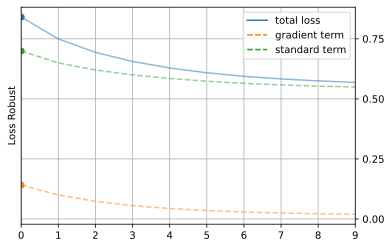

no filename given


In [25]:
print(f'{trainer_rnode.eps = }')
loss_evolution(trainer_rnode, 0)

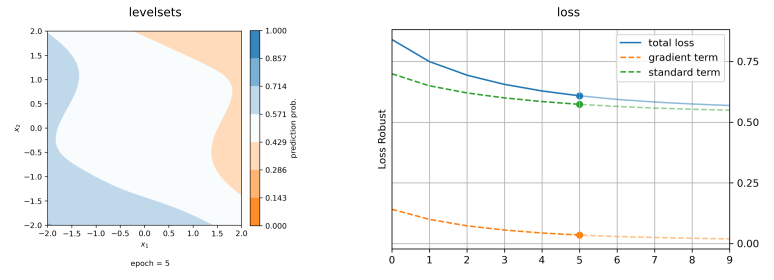

In [26]:
from plots.plots import comparison_plot

epoch = 5
fig_name_base = os.path.join('evo_circ', '')
loss_evolution(trainer_rnode, epoch, 'loss_pic')
comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'test', show = True, figsize = (12,4))

## gif generation

In [27]:
# loss_imgs = []
# fig_name_basis = os.path.join('epoch_evo_circ', '')
# gif_name = os.path.join('epoch_evo_circ', 'loss_evo_comp.gif')
# for epoch in range(0,num_epochs,plotfreq):
#     print(epoch)
#     loss_evolution(trainer_anode, epoch, 'loss_pic')
#     fig1_name = fig_name_basis + str(epoch) + '.png'
#     comparison_plot(fig1_name, 'levelsets', 'loss_pic.png', 'loss', 'comp_run.png', show = False, figsize = (12,4))
    
#     loss_imgs.append(imageio.imread('comp_run.png'))
#         # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
# imageio.mimwrite(gif_name, loss_imgs, fps = 1)

# for epoch in range(1,num_epochs+1,plotfreq):
#     if epoch not in [0, num_epochs//5, num_epochs//2, num_epochs-1]: os.remove(fig1_name) 

In [28]:
# def train_evo_gif(trainer, num_epochs, plotfreq, subfolder, gif_name, title_left = 'levelsets', title_right = 'loss', fps = 1):
#     if not os.path.exists(subfolder):
#         os.makedirs(subfolder)
    
#     imgs = []
#     fig_name_basis = os.path.join(subfolder, '')
#     gif_name = os.path.join(subfolder, gif_name + '.gif')
#     for epoch in range(0,num_epochs,plotfreq):
#         print(epoch)
#         loss_evolution(trainer, epoch, 'loss_pic')
#         fig1_name = fig_name_basis + str(epoch) + '.png'
#         comparison_plot(fig1_name, title_left, 'loss_pic.png', title_right , 'comp_run.png', show = False, figsize = (12,4))
        
#         imgs.append(imageio.imread('comp_run.png'))
#             # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
#     imageio.mimwrite(gif_name, imgs, fps = fps)
#     print(gif_name, ' created')

In [29]:
from plots.gifs import train_evo_gif
train_evo_gif(trainer_anode, num_epochs, plotfreq, subfolder, 'rob')

0
5
evo_circ/rob.gif  created


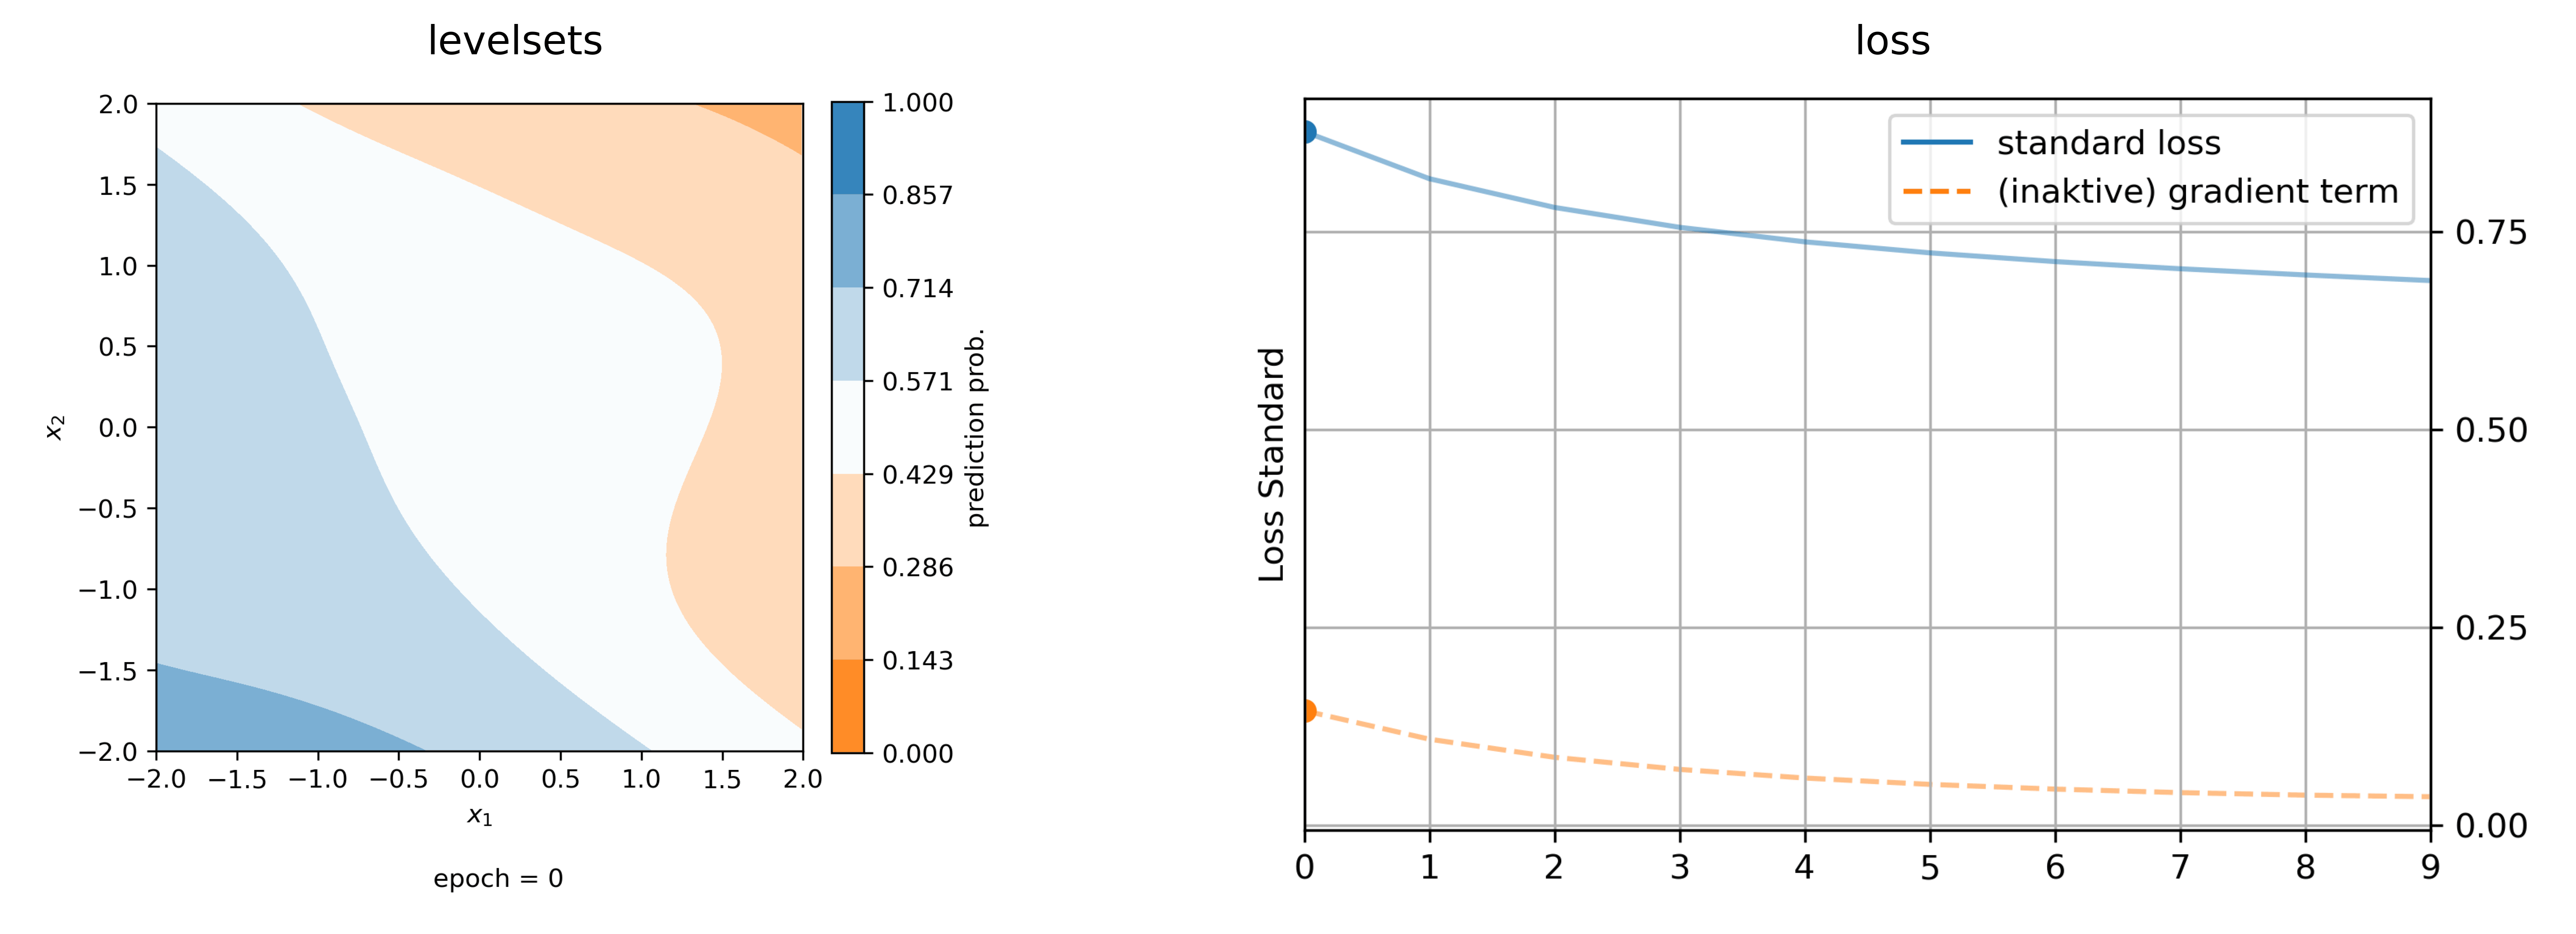

In [30]:
from IPython.display import Image
Image(filename = os.path.join(subfolder, 'loss_evo_comp.gif'), width = 800)

FileNotFoundError: No such file: '/Users/Tobi/FAUbox/Python/tw_robust nODEs/epoch_evo_circ/rob0.png'

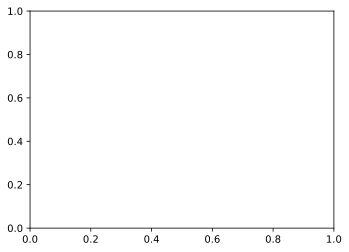

In [31]:
loss_imgs = []
fig_name_base = os.path.join('epoch_evo_circ','rob')
gif_name = os.path.join('epoch_evo_circ', 'loss_evo_rob_comp.gif')
for epoch in range(0,num_epochs,plotfreq):
  
    loss_evolution(trainer_rnode, epoch, 'loss_pic')
    comparison_plot(fig_name_base + str(epoch) + '.png', 'levelsets', 'loss_pic.png', 'loss', 'comp_run.png', show = False, figsize = (12,4))
    
    loss_imgs.append(imageio.imread('comp_run' + '.png'))
        # if not (num_steps == layer + 1): os.remove(fig_name_rob) #keep last image
imageio.mimwrite(gif_name, loss_imgs, fps = 1)

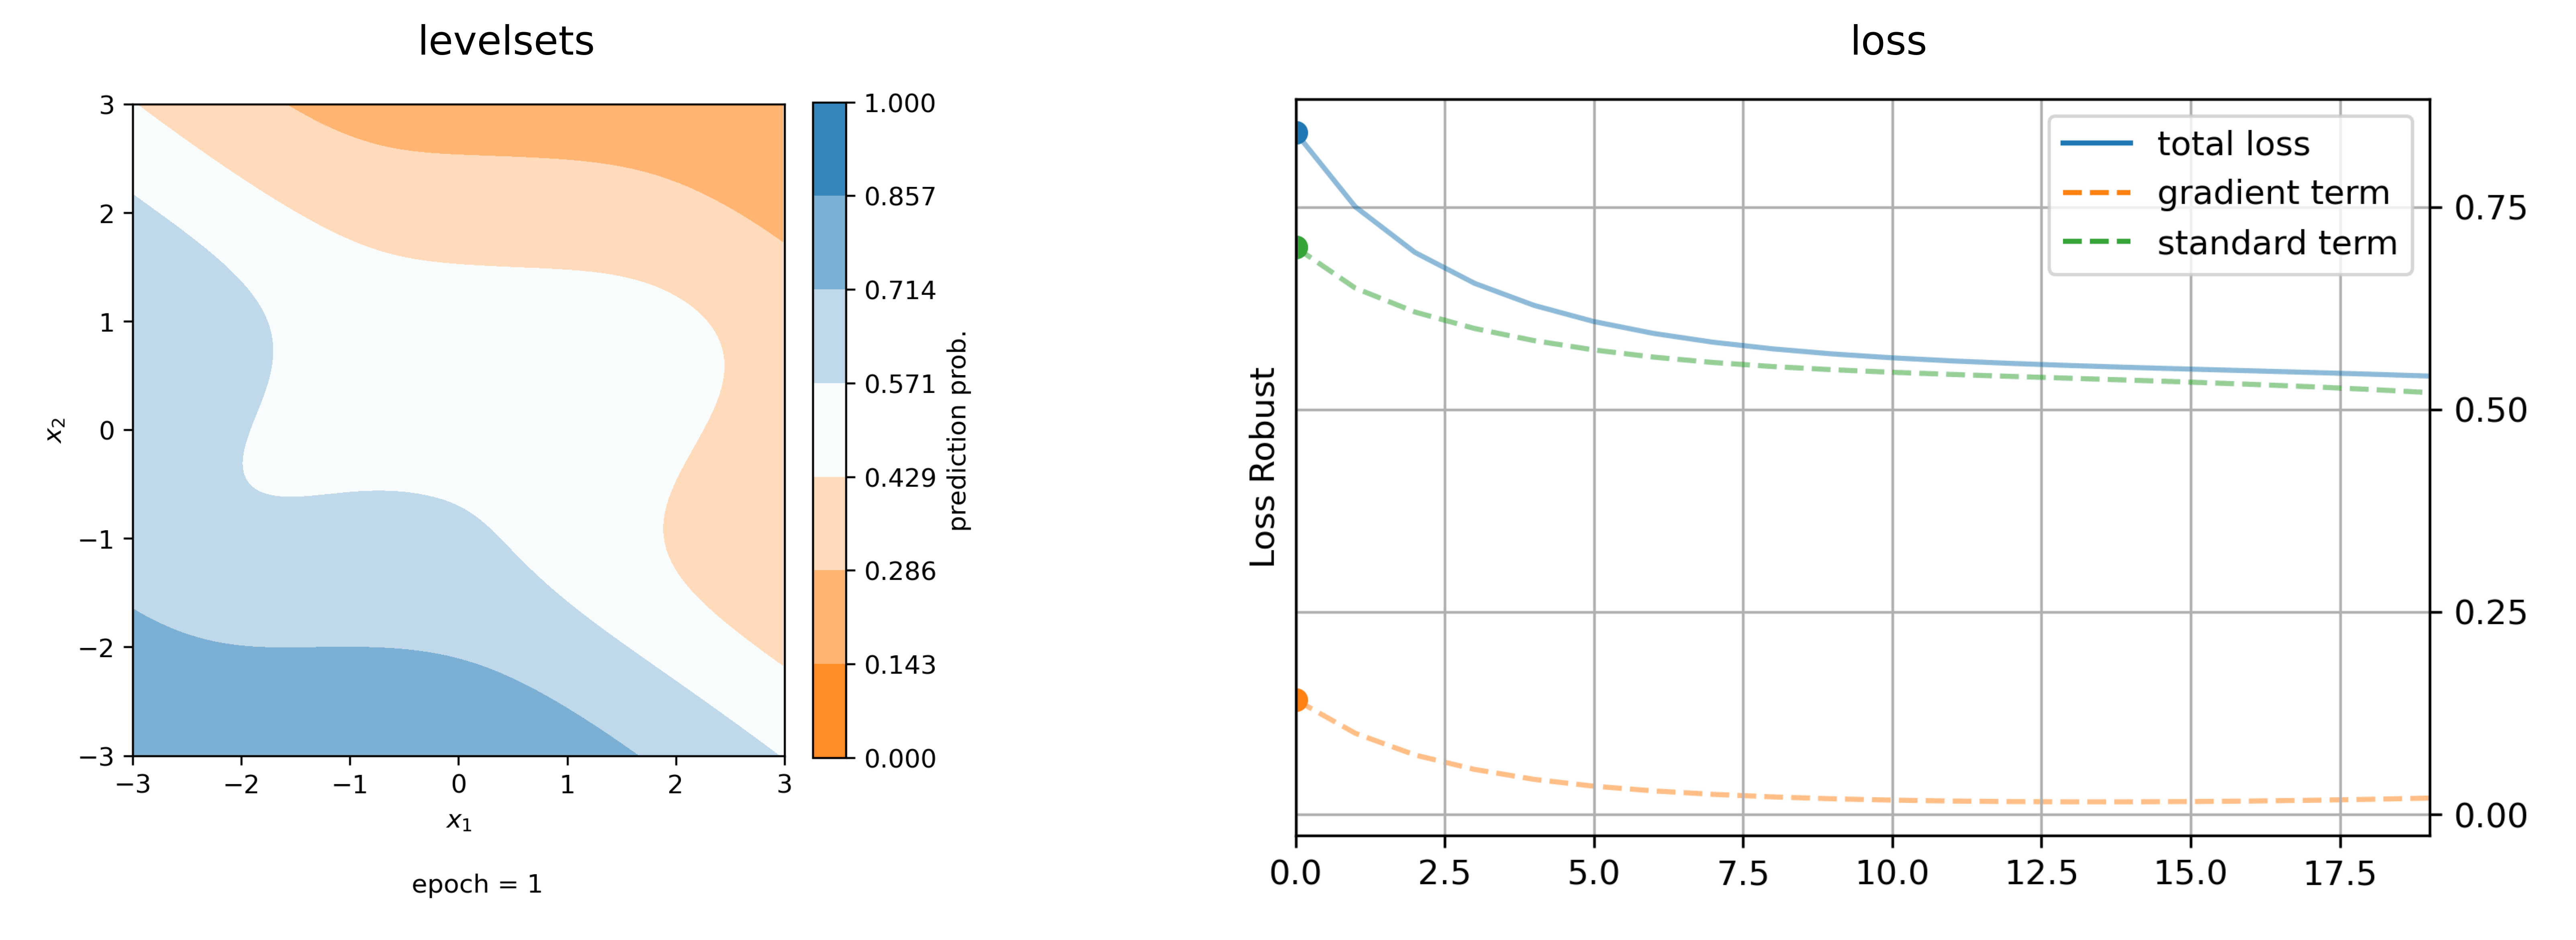

In [ ]:
from IPython.display import Image
Image(filename = gif_name, width = 800)